In [219]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 343
tf.random.set_seed(seed)
np.random.seed(seed)

In [220]:
data_dir = pathlib.Path('./data')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != '.ipynb_checkpoints']
print('Commands:', commands)

Commands: ['off' 'on']


In [221]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 61
Number of examples per label: 34
Example file tensor: tf.Tensor(b'data/off/rec29.wav', shape=(), dtype=string)


In [222]:
train_files = filenames[:30]
val_files = filenames[30:50]
test_files = filenames[40:61]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 30
Validation set size 20
Test set size 21


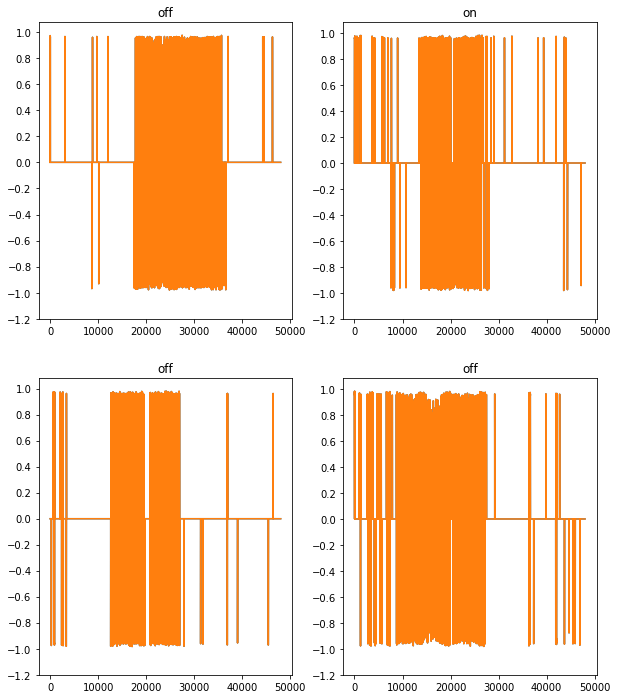

In [223]:
AUTOTUNE = tf.data.AUTOTUNE

def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return audio

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_mel_spectrogram(spectrogram):
  num_mel_bins = 64
  # spectrograml = tf.expand_dims(spectrogram, -1)
  num_spectrogram_bins = spectrogram.shape[-1]
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, 16000, 100,
        500)

  mel_spectrograms = tf.tensordot(
      spectrogram, linear_to_mel_weight_matrix, 1)

  log_offset = 1e-6
  log_mel_spectrograms = tf.math.log(mel_spectrograms + log_offset)

  # Step 5 : log_mel_spectrograms->mfccs
  # Keep the first `num_mfccs` MFCCs.
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :30]
  return mfccs

def get_spectrogram(waveform):
  waveform = tf.cast(waveform, tf.float32)
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

def get_spectrogram_and_label_id(audio, label):
  waveform = audio[:,0]
  spectrogram = get_spectrogram(waveform)
  mfccs = tf.expand_dims(spectrogram, -1)
  # mfccs = get_mel_spectrogram(spectrogram)
  # mfccs = tf.expand_dims(mfccs, -1)
  label_id = tf.argmax(label == commands)
  return mfccs, label_id

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds


def plot_spectrogram(spectrogram, plot):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  plt.pcolormesh(X, Y, log_spec)
  plt.show()

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [224]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  waveform = waveform[:,0]
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)


Label: off
Waveform shape: (48000,)
Spectrogram shape: (374, 129)


In [225]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [226]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(128, 128), 
    norm_layer,
    layers.Conv2D(8, 3, activation='relu'),
    layers.Conv2D(4, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (374, 129, 1)


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_20 (Resizing)       (None, 128, 128, 1)       0         
_________________________________________________________________
normalization_37 (Normalizat (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 126, 126, 8)       80        
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 124, 124, 4)       292       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 62, 62, 4)         0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 62, 62, 4)         0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 15376)           

Epoch 1/10
1/1 [==============================] - 1s 819ms/step - loss: 0.7206 - accuracy: 0.5667 - val_loss: 0.6590 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 221ms/step - loss: 0.6499 - accuracy: 0.6333 - val_loss: 0.6898 - val_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 0s 214ms/step - loss: 0.5999 - accuracy: 0.5667 - val_loss: 0.7694 - val_accuracy: 0.6000
Epoch 00003: early stopping


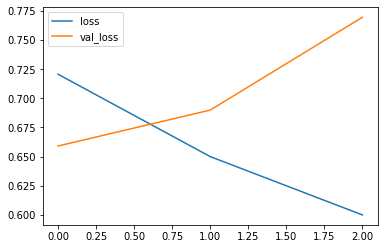

In [227]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [228]:

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 57%


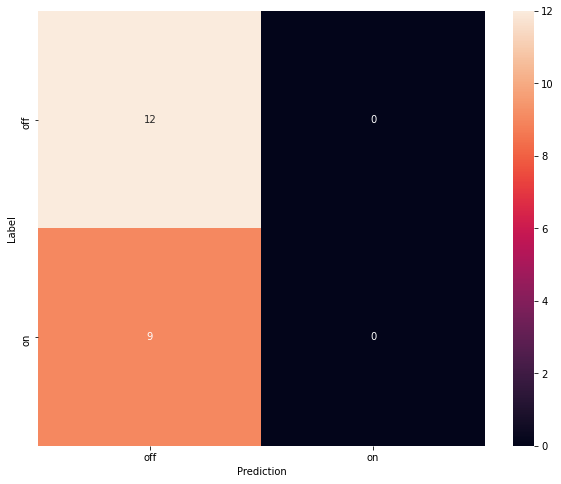

In [229]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

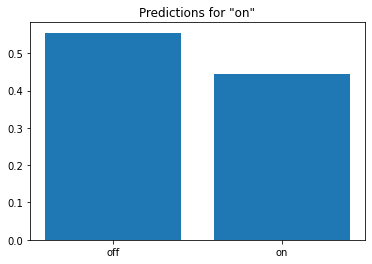

In [230]:
sample_file = data_dir/'on/rec5.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [231]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open('models/speech.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmper3npp6d/assets


INFO:tensorflow:Assets written to: /tmp/tmper3npp6d/assets
2021-07-30 10:01:28.756951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-30 10:01:28.757436: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-07-30 10:01:28.757525: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-07-30 10:01:28.757862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-30 10:01:28.758247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95

66720

In [232]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_MODEL_H\n'
  c_str += '#define ' + var_name.upper() + '_MODEL_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_model_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '_model[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Write TFLite model to a C source (or header) file
with open('models/speech.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, 'speech'))